# data download

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
import re
import os
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PairwiseDistance, PersistenceLandscape, BettiCurve
from scipy.spatial.distance import pdist, squareform
import pickle
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
starttrain = '2010-01-01'
endtrain = '2018-12-31'
startval = '2019-01-01'
endval = '2021-12-31'
starttest = '2022-01-01'
endtest = '2025-04-16'
ticker = "PFE"

if os.path.exists("pfe_data.csv"):
    train = pd.read_csv("pfe_data.csv", skiprows=[1, 2], parse_dates=["Price"])
    train = train.rename(columns={"Price": "Date"})
    train.set_index("Date", inplace=True)
    train = train.shift(1)

else:
    train = yf.download("PFE", start=starttrain, end=endtest)
    train.to_csv("pfe_data.csv")

train

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,9.683944,9.689059,9.330964,9.346310,54898644.0
2010-01-06,9.545827,9.683950,9.489555,9.678834,45714931.0
2010-01-07,9.515131,9.622560,9.469090,9.545825,43640975.0
2010-01-08,9.479321,9.550940,9.443511,9.535593,41557112.0
...,...,...,...,...,...
2025-04-09,21.431154,22.559626,21.038643,22.471310,72406000.0
2025-04-10,22.068985,22.118050,20.528376,20.714820,95954400.0
2025-04-11,21.185833,21.853104,20.695193,21.843291,72960700.0


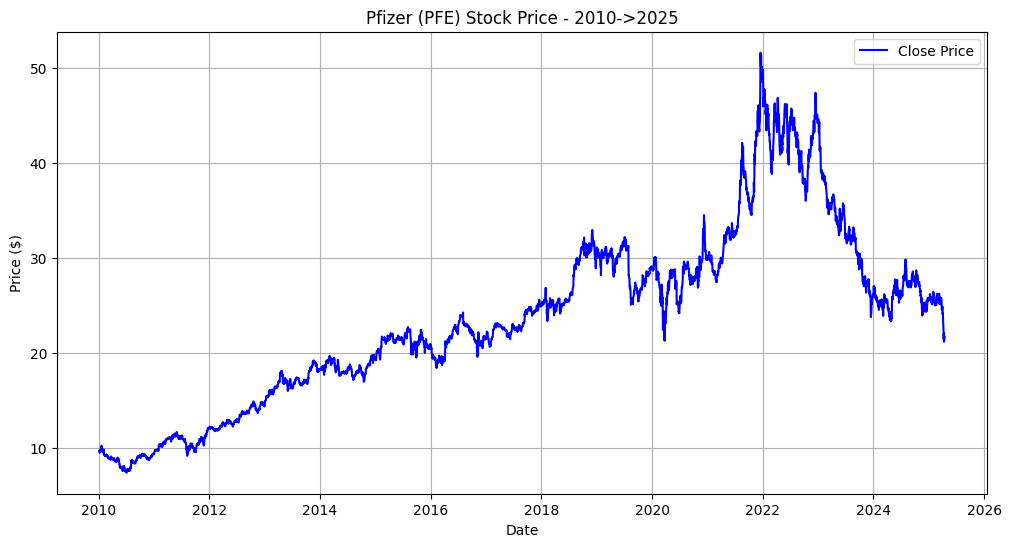

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Close"], label="Close Price", color='blue')
plt.title("Pfizer (PFE) Stock Price - 2010->2025")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# feature engineering

## technical indicators

In [4]:
def compute_rolling_volatility(close, window=10):
    returns = close.pct_change()
    return returns.rolling(window=window).std()

def compute_momentum(close, lags=[1, 5]):
    return {f'momentum_{lag}d': close.pct_change(periods=lag) for lag in lags}

def compute_rsi(close, window=14):
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_bollinger_zscore(close, window=20):
    ma = close.rolling(window=window).mean()
    std = close.rolling(window=window).std()
    return (close - ma) / std

def compute_atr(high, low, close, window=14):
    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window=window).mean()

In [5]:
close = train['Close']
high = train['High']
low = train['Low']
Open = train['Open']


volatility_10d = compute_rolling_volatility(close)
momentum = compute_momentum(close)
rsi_14d = compute_rsi(close)
bollinger_z = compute_bollinger_zscore(close)
atr_14d = compute_atr(high, low, close)

volatility_norm = volatility_10d / close.rolling(10).mean()
atr_norm = atr_14d / close.rolling(14).mean()

tech_features = pd.DataFrame({
    'volatility_10d': volatility_norm,
    'rsi_14d': rsi_14d,
    'bollinger_zscore': bollinger_z,
    'atr_14d': atr_norm,
    **momentum
})

tech_features

,volatility_10d,rsi_14d,bollinger_zscore,atr_14d,momentum_1d,momentum_5d
Date,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,-0.014262,NaN
2010-01-07,NaN,NaN,NaN,NaN,-0.003216,NaN
2010-01-08,NaN,NaN,NaN,NaN,-0.003764,NaN
...,...,...,...,...,...,...
2025-04-09,0.000851,10.488209,-2.534981,0.029402,-0.034909,-0.110024
2025-04-10,0.001056,19.967487,-1.744052,0.033635,0.029762,-0.089474
2025-04-11,0.001139,16.355780,-1.997092,0.036740,-0.040018,-0.111157


## sentiment/news

### insider sentiment

In [6]:
def clean_text(text):
    if text is None:
        return None
    return re.sub(r'\s+', ' ', text).strip()

def parse_form4(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    
    try:
        soup = BeautifulSoup(content, 'lxml-xml')
    except:
        try:
            soup = BeautifulSoup(content, 'html.parser')
        except Exception as e:
            print(f"Failed to parse {file_path}: {e}")
            return []
    
    transactions = []
    issuer = soup.find('issuer')
    issuer_name = clean_text(issuer.find('issuerName').text) if issuer and issuer.find('issuerName') else None
    ticker = clean_text(issuer.find('issuerTradingSymbol').text) if issuer and issuer.find('issuerTradingSymbol') else None

    owner = soup.find('reportingOwner')
    owner_name = clean_text(owner.find('rptOwnerName').text) if owner and owner.find('rptOwnerName') else None
    owner_title = clean_text(owner.find('officerTitle').text) if owner and owner.find('officerTitle') else None

    for transaction in soup.find_all('nonDerivativeTransaction'):
        try:
            date_element = transaction.find('transactionDate')
            date_text = clean_text(date_element.text) if date_element else None
            if not date_text:
                continue
                
            try:
                date = datetime.strptime(date_text, '%Y-%m-%d').date()
            except ValueError:
                continue
            
            shares_element = transaction.find('transactionShares')
            shares_text = clean_text(shares_element.text) if shares_element else None
            try:
                shares = float(shares_text) if shares_text else None
            except (ValueError, TypeError):
                shares = None
            
            price_element = transaction.find('transactionPricePerShare')
            price_text = clean_text(price_element.text) if price_element else None
            try:
                price = float(price_text) if price_text else 0
            except (ValueError, TypeError):
                price = 0
            
            code_element = transaction.find('transactionAcquiredDisposedCode')
            code = clean_text(code_element.text) if code_element else None
            
            transaction_code_element = transaction.find('transactionCode')
            transaction_code = clean_text(transaction_code_element.text) if transaction_code_element else None
            
            if code == 'A' or transaction_code in ['P', 'A']:
                action = 'Buy'
            elif code == 'D' or transaction_code in ['S', 'F']:
                action = 'Sell'
            else:
                action = 'Other'

            dollar_value = shares * price if (price > 0 and shares is not None) else None
            
            transactions.append({
                'Date': date,
                'Issuer': issuer_name,
                'Ticker': ticker,
                'Insider': owner_name,
                'Title': owner_title,
                'Shares': shares,
                'Price': price if price > 0 else None,
                'Action': action,
                'Value': dollar_value,
                'TransactionCode': transaction_code,
                'AcquiredDisposedCode': code,
                'SourceFile': os.path.basename(file_path)
            })
        except Exception as e:
            print(f"Error processing transaction in {file_path}: {str(e)[:100]}...")
            continue
    
    return transactions

def process_form4_directory(directory):
    all_transactions = []
    processed_files = 0
    error_files = 0
    
    for folder in os.listdir(directory):
        folderpath = os.path.join(directory,folder)
        for filename in os.listdir(folderpath):
            if filename.endswith('.txt'):
                file_path = os.path.join(folderpath, filename)
                try:
                    transactions = parse_form4(file_path)
                    if transactions:
                        all_transactions.extend(transactions)
                        processed_files += 1
                    else:
                        error_files += 1
                except Exception as e:
                    error_files += 1
                    print(f"Failed to process {filename}: {str(e)[:100]}...")
    
    print(f"\nProcessing complete. Success: {processed_files}, Errors: {error_files}")

    df = pd.DataFrame(all_transactions)

    if not df.empty:
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
    
    return df


if os.path.exists("insider_transactions_clean.csv"):
    transactions_df = pd.read_csv("insider_transactions_clean.csv", index_col=0, parse_dates=True)

else:
    form4_directory = "./sec-edgar-filings/PFE/4"
    transactions_df = process_form4_directory(form4_directory)
    print("\nSample transactions:")
    print(transactions_df.head())
    output_file = 'insider_transactions_clean.csv'
    transactions_df.to_csv(output_file)
    print(f"\nSaved results to {output_file}")

transactions_df = transactions_df.drop(['Issuer', 'Ticker', 'Insider', 'Title', 'Shares', 'Price', 'TransactionCode', 'AcquiredDisposedCode', 'SourceFile'], axis=1)
transactions_df['Value'] = transactions_df['Value'] * transactions_df['Action'].map({'Buy': 1, 'Sell': -1})
transactions_df.drop('Action', axis=1, inplace=True)

In [7]:
transactions_df

,Value
Date,
2016-12-20,51427.44
2016-12-28,-777.12
2017-02-27,NaN
2017-02-27,NaN
2017-02-27,-227933.75
...,...
2025-02-27,18248188.13
2025-02-27,-28918.80
2025-02-27,-19548.90


In [8]:
BASE_DIR = "./sec-edgar-filings/PFE"
ticker = "PFE"
form_types = ["10-K", "10-Q", "8-K"]
# Ensure directory exists
os.makedirs(BASE_DIR, exist_ok=True)

In [9]:
def extract_filing_date_from_submission(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:

        raw_head = f.read(20000)

    m = re.search(r"FILED AS OF DATE:\s*(\d{8})", raw_head)
    if m:
        ymd = m.group(1)
        return datetime.strptime(ymd, "%Y%m%d").date()

    m = re.search(r"<ACCEPTANCE-DATETIME>(\d{8})\d{6}", raw_head)
    if m:
        ymd = m.group(1)
        return datetime.datetime.strptime(ymd, "%Y%m%d").date()

    return None

In [10]:
if os.path.exists("other_forms.csv"):
    filing_df = pd.read_csv("other_forms.csv", index_col=0, parse_dates=True)

else:
    filings = []

    for form in form_types:
        form_dir = os.path.join(BASE_DIR, form)
        if not os.path.isdir(form_dir):
            continue
    
        for accession in os.listdir(form_dir):
            accession_path = os.path.join(form_dir, accession)
            if not os.path.isdir(accession_path):
                continue
    
            submission_path = os.path.join(accession_path, "full-submission.txt")
            if not os.path.exists(submission_path):
                continue
    
            file_date = extract_filing_date_from_submission(submission_path)
            if file_date is None:
    
                continue
            
            filings.append((file_date, form))
    
    filings.sort(key=lambda x: x[1])
    print(f"Total filings found: {len(filings)}")
    filing_df = pd.DataFrame(filings, columns=['filing_date', 'form'])
    output_file = 'other_forms.csv'
    filing_df.to_csv(output_file)
    print(f"\nSaved results to {output_file}")


filing_df['filing_date'] = pd.to_datetime(filing_df['filing_date'])

date_range = pd.date_range(start="2010-01-01", end="2025-12-31", freq='D')
df = pd.DataFrame(index=date_range)
df.index.name = 'Date'

df_10k = filing_df[filing_df['form'] == '10-K'].sort_values('filing_date')
df_10q = filing_df[filing_df['form'] == '10-Q'].sort_values('filing_date')
df_8k  = filing_df[filing_df['form'] == '8-K'].sort_values('filing_date')

def days_until_next(filing_dates, all_dates):
    return all_dates.to_series().apply(
        lambda d: (filing_dates[filing_dates > d].min() - d).days 
        if (filing_dates > d).any() else np.nan
    )

def days_since_last(filing_dates, all_dates):
    return all_dates.to_series().apply(
        lambda d: (d - filing_dates[filing_dates <= d].max()).days 
        if (filing_dates <= d).any() else np.nan
    )

df['days_before_10k_filing'] = days_until_next(df_10k['filing_date'].values, df.index)
df['days_after_10q_filing'] = days_since_last(df_10q['filing_date'].values, df.index)
df['days_after_8k_filing']  = days_since_last(df_8k['filing_date'].values, df.index)

df = df.dropna(how='all')
df 

Total filings found: 255

Saved results to other_forms.csv


,days_before_10k_filing,days_after_10q_filing,days_after_8k_filing
Date,,,
2010-01-01,56.0,NaN,NaN
2010-01-02,55.0,NaN,NaN
2010-01-03,54.0,NaN,NaN
2010-01-04,53.0,NaN,NaN
2010-01-05,52.0,NaN,NaN
...,...,...,...
2025-12-27,NaN,418.0,326.0
2025-12-28,NaN,419.0,327.0
2025-12-29,NaN,420.0,328.0


In [11]:
df = df.merge(transactions_df, on="Date", how="left")
df['Recency_8k'] = pd.cut(df['days_after_8k_filing'], bins=[0, 5, 20, 60, 100], labels=[0, 1, 2, 3])
df['pre_10k_flag'] = ( df['days_before_10k_filing']<= 5).astype(int)
df = df.drop(['days_after_10q_filing',	'days_before_10k_filing', 'days_after_8k_filing'], axis=1)
df

,Value,Recency_8k,pre_10k_flag
Date,,,
2010-01-01,NaN,NaN,0
2010-01-02,NaN,NaN,0
2010-01-03,NaN,NaN,0
2010-01-04,NaN,NaN,0
2010-01-05,NaN,NaN,0
...,...,...,...
2025-12-27,NaN,NaN,0
2025-12-28,NaN,NaN,0
2025-12-29,NaN,NaN,0


## Extreme Events (EE) {ex. COVID-19} 

In [12]:
def compute_log_returns(prices):
    return np.log(prices / prices.shift(1)).dropna()

def create_point_cloud(returns, window=60):
    point_clouds = []
    for i in range(window, len(returns)):
        window_data = returns.iloc[i-window:i]
        point_clouds.append(window_data.values)
    return point_clouds

def compute_persistence(point_clouds, homology_dimensions=[0, 1]):
    vr = VietorisRipsPersistence(
        metric='euclidean', 
        homology_dimensions=homology_dimensions,
        n_jobs=-1  
    )
    return vr.fit_transform(point_clouds)

def compute_wasserstein_distances(diagrams):
    wasserstein = PairwiseDistance(metric='wasserstein', order=1)
    wd_distances = []
    for i in range(1, len(diagrams)):
        dist_matrix = wasserstein.fit_transform([diagrams[i-1], diagrams[i]])
        wd_distances.append(dist_matrix[0, 1])
    return wd_distances

def compute_norms(diagrams, norm_type=2, dimension=1):
    norms = []
    for diagram in diagrams:
        dim_diagram = [pt for pt in diagram if pt[2] == dimension]
        if not dim_diagram:
            norms.append(0)
            continue

        landscape = PersistenceLandscape(n_layers=5).fit_transform([dim_diagram])[0]
        if norm_type == 1:
            norms.append(np.linalg.norm(landscape.flatten(), ord=1))
        else:  
            norms.append(np.linalg.norm(landscape.flatten(), ord=2))
    return norms

def extract_tda_features(tickers, start_date, end_date, window=60):
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    closes = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
    closes = closes.shift(1)
    returns = compute_log_returns(closes)

    point_clouds = create_point_cloud(returns, window)

    diagrams = compute_persistence(point_clouds)

    wd = compute_wasserstein_distances(diagrams)
    l1_norms = compute_norms(diagrams, norm_type=1)
    l2_norms = compute_norms(diagrams, norm_type=2)

    dates = returns.index[window+1:-1]
    wd = wd[1:]
    
    return pd.DataFrame({
        'date': dates,
        'wasserstein': wd,
        'l1_norm': l1_norms[1:-1],  
        'l2_norm': l2_norms[1:-1]
    }).set_index('date')

def create_volatility_features(tda_features, threshold_multiplier=4):
    features = tda_features.copy()
    for col in features.columns:
        mean = features[col].mean()
        std = features[col].std()
        threshold = mean + threshold_multiplier * std
        features[f'{col}_spike'] = (features[col] > threshold).astype(int)

    for col in ['wasserstein', 'l1_norm', 'l2_norm']:
        spike_dates = features[features[f'{col}_spike'] == 1].index
        features[f'days_since_{col}_spike'] = features.index.to_series().apply(
            lambda x: (x - spike_dates[spike_dates <= x].max()).days 
            if any(spike_dates <= x) else np.nan
        )
    
    return features

def create_interaction_features(features, sector_returns):
    """Create interaction features with sector returns"""
    merged = features.join(sector_returns, how='left')

    for col in ['wasserstein', 'l1_norm', 'l2_norm']:
        merged[f'topo_{col}_sector_interaction'] = (
            merged[f'{col}_spike'] * merged['sector_return']
        )
    
    return merged

In [13]:
tickers = ['PFE', 'JNJ', 'AZN'] 
sector_ticker = 'IBB'  
start_date = starttrain
end_date = endtest
window = 60 

if os.path.exists("tda_market_features.csv"):
    full_features = pd.read_csv("tda_market_features.csv", index_col=0, parse_dates=True)

else:
    tda_features = extract_tda_features(tickers, start_date, end_date, window)
    sector = yf.download(sector_ticker, start_date, end_date)['Close']
    sector = sector.shift(1)
    sector_returns = compute_log_returns(sector).rename(columns={'IBB': 'sector_return'})
    print(sector_returns.columns)
    volatility_features = create_volatility_features(tda_features, threshold_multiplier=2)
    
    full_features = create_interaction_features(volatility_features, sector_returns)
    
    for col in ['wasserstein', 'l1_norm', 'l2_norm']:
        full_features[f'{col}_ma30'] = full_features[col].rolling(30).mean()
        
    full_features.to_csv('tda_market_features.csv')
    print("Feature extraction complete. Features saved to tda_market_features.csv")

In [14]:
full_features.index.rename('Date', inplace=True)
full_features = full_features.drop(['wasserstein', 'l1_norm', 'l2_norm', 'wasserstein_spike', 'l1_norm_spike', 'l2_norm_spike', 'wasserstein_ma30', 'l1_norm_ma30', 'l2_norm_ma30'], axis=1)
full_features

,days_since_wasserstein_spike,days_since_l1_norm_spike,days_since_l2_norm_spike,sector_return,topo_wasserstein_sector_interaction,topo_l1_norm_sector_interaction,topo_l2_norm_sector_interaction
Date,,,,,,,
2010-04-06,NaN,NaN,NaN,0.008241,0.0,0.000000,0.000000
2010-04-07,NaN,NaN,NaN,-0.000216,-0.0,-0.000000,-0.000000
2010-04-08,NaN,NaN,NaN,-0.005415,-0.0,-0.000000,-0.000000
2010-04-09,NaN,NaN,NaN,-0.000435,-0.0,-0.000000,-0.000000
2010-04-12,NaN,NaN,NaN,0.000326,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...
2025-04-08,1.0,0.0,0.0,-0.008142,-0.0,-0.008142,-0.008142
2025-04-09,2.0,0.0,0.0,-0.036721,-0.0,-0.036721,-0.036721
2025-04-10,3.0,0.0,0.0,0.057332,0.0,0.057332,0.057332


### combining all features

In [15]:
ohlc = train.copy()
ohlc = ohlc[["Close", "Volume"]]
final_features = ohlc \
    .merge(tech_features, on="Date", how="left") \
    .merge(df, on="Date", how="left") \
    .merge(full_features, on="Date",how="left")

final_features['Value'] = final_features['Value'].fillna(0)

final_features = final_features.drop(final_features.index[0])
final_features = final_features.drop(columns=['topo_wasserstein_sector_interaction',	'topo_l1_norm_sector_interaction',	'topo_l2_norm_sector_interaction']) 
final_features

,Close,Volume,volatility_10d,rsi_14d,bollinger_zscore,atr_14d,momentum_1d,momentum_5d,Value,Recency_8k,pre_10k_flag,days_since_wasserstein_spike,days_since_l1_norm_spike,days_since_l2_norm_spike,sector_return
Date,,,,,,,,,,,,,,,
2010-01-05,9.683944,54898644.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,NaN,NaN
2010-01-06,9.545827,45714931.0,NaN,NaN,NaN,NaN,-0.014262,NaN,0.0,NaN,0,NaN,NaN,NaN,NaN
2010-01-07,9.515131,43640975.0,NaN,NaN,NaN,NaN,-0.003216,NaN,0.0,NaN,0,NaN,NaN,NaN,NaN
2010-01-08,9.479321,41557112.0,NaN,NaN,NaN,NaN,-0.003764,NaN,0.0,NaN,0,NaN,NaN,NaN,NaN
2010-01-11,9.556053,32049716.0,NaN,NaN,NaN,NaN,0.008095,NaN,0.0,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09,21.431154,72406000.0,0.000851,10.488209,-2.534981,0.029402,-0.034909,-0.110024,0.0,3,0,2.0,0.0,0.0,-0.036721
2025-04-10,22.068985,95954400.0,0.001056,19.967487,-1.744052,0.033635,0.029762,-0.089474,0.0,3,0,3.0,0.0,0.0,0.057332
2025-04-11,21.185833,72960700.0,0.001139,16.355780,-1.997092,0.036740,-0.040018,-0.111157,0.0,3,0,4.0,1.0,1.0,-0.047383


# Modelling

In [16]:
final_features['next_day_return'] = final_features['Close'].pct_change().shift(-2)

In [17]:
X = final_features.drop(columns=['next_day_return', 'Close'])  
y = final_features[['next_day_return']] 
valid_idx = y['next_day_return'].notna()

X = X[valid_idx]
y = y[valid_idx]

X_train = X.loc[starttrain:endtrain]
y_train = y.loc[starttrain:endtrain]

X_val = X.loc[startval:endval]
y_val = y.loc[startval:endval]

X_test = X.loc[starttest:endtest]
y_test = y.loc[starttest:endtest]

In [18]:
model_path = "xgb_model_1.3.pkl"

if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        model = pickle.load(f)
else:
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        missing=np.nan,
        random_state=42,
        enable_categorical=True
    )
    
    model.fit(X_train, y_train)

    with open(model_path, "wb") as f:
        pickle.dump(model, f)

In [19]:
y_test_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=['predicted_return'])

y_test_pred['predicted_return'] *= -1
y_test_pred['signal'] = y_test_pred['predicted_return'].apply(lambda x: 1 if x > 0 else -1)

In [20]:
df_signals = pd.concat([y_test, y_test_pred], axis=1)
df_signals

,next_day_return,predicted_return,signal
Date,,,
2022-01-03,-0.037423,-0.003449,-1
2022-01-04,0.020173,-0.002653,-1
2022-01-05,-0.014201,-0.005304,-1
2022-01-06,0.016047,-0.007405,-1
2022-01-07,0.009332,-0.003722,-1
...,...,...,...
2025-04-07,-0.034909,0.004842,1
2025-04-08,0.029762,-0.029745,-1
2025-04-09,-0.040018,-0.021758,-1


## Sanity Check w/ Simple strategies

In [21]:
close_base = train['Close'] 
close_base

Date
2010-01-04          NaN
2010-01-05     9.683944
2010-01-06     9.545827
2010-01-07     9.515131
2010-01-08     9.479321
                ...    
2025-04-09    21.431154
2025-04-10    22.068985
2025-04-11    21.185833
2025-04-14    21.499844
2025-04-15    21.705912
Name: Close, Length: 3845, dtype: float64

In [22]:
daily_returns = close_base.pct_change()  
position = 1 
capital = 1_000_000  

daily_pnl = capital * position * daily_returns

In [23]:
ma_short = close_base.rolling(5).mean()
ma_long = close_base.rolling(20).mean()
ma_signal = (ma_short > ma_long).astype(int).replace(0, -1)
ma_pnl = capital * ma_signal.shift(1) * daily_returns

In [24]:
rolling_mean = close_base.rolling(20).mean()
rolling_std = close_base.rolling(20).std()
upper = rolling_mean + 2 * rolling_std
lower = rolling_mean - 2 * rolling_std

bollinger_signal = pd.Series(0, index=close_base.index)
bollinger_signal[close > upper] = -1
bollinger_signal[close < lower] = 1
bollinger_pnl = capital * bollinger_signal.shift(1) * daily_returns

In [25]:
delta = close_base.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

rsi_signal = pd.Series(0, index=close_base.index)
rsi_signal[rsi < 30] = 1
rsi_signal[rsi > 70] = -1
rsi_pnl = capital * rsi_signal.shift(1) * daily_returns

In [26]:
np.random.seed(44)
random_signal = pd.Series(np.random.choice([-1, 1], size=len(close_base)), index=close_base.index)
random_pnl = capital * random_signal.shift(1) * daily_returns

In [27]:
ma_50 = close_base.rolling(50).mean()
momentum_5d = close_base.pct_change(5)

signal = ((momentum_5d > 0) & (close_base > ma_50)).astype(int) * 1
filtered_momentum_pnl = capital * signal.shift(1) * daily_returns

In [28]:
vol_20d = close_base.pct_change().rolling(20).std()

signal = pd.Series(0, index=close_base.index)
signal[vol_20d > vol_20d.median()] = (momentum_5d > 0).astype(int) * 1
signal[vol_20d <= vol_20d.median()] = (momentum_5d < 0).astype(int) * -1

vol_regime_pnl = capital * signal.shift(1) * daily_returns

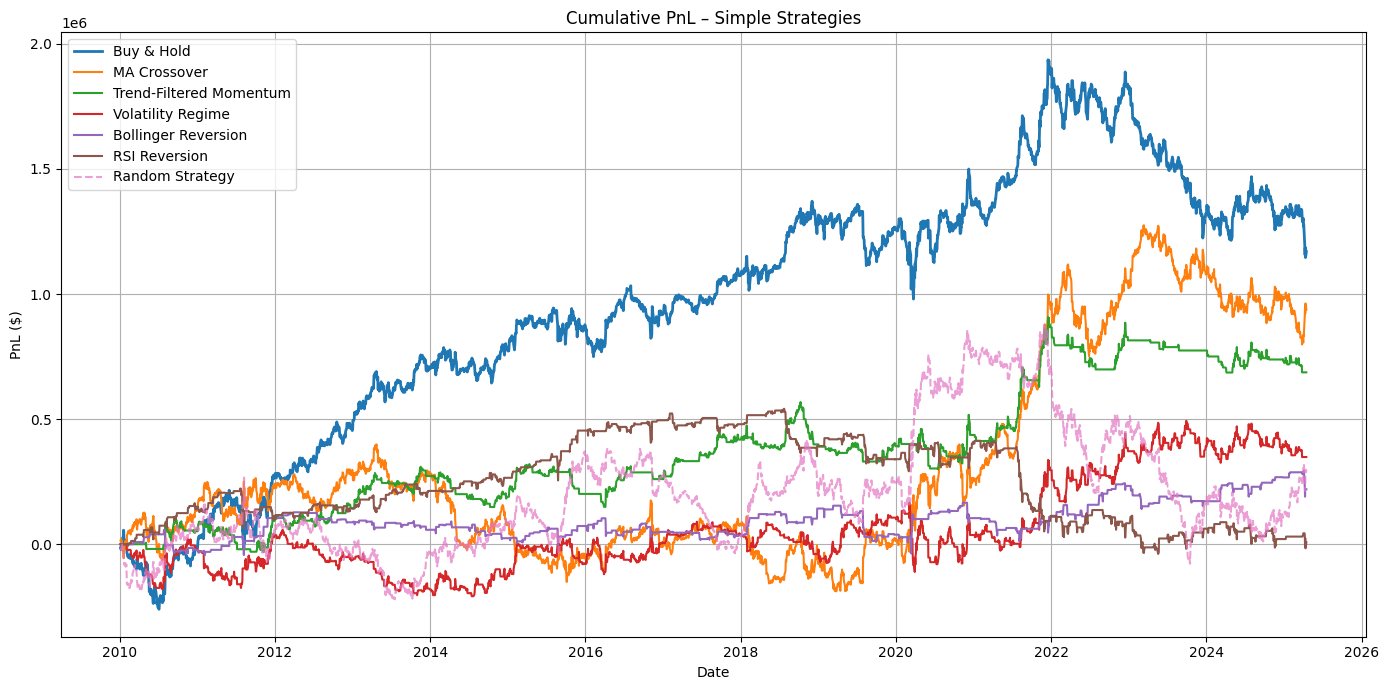

In [29]:
cumulative_pnl = daily_pnl.cumsum()
plt.figure(figsize=(14, 7))
plt.plot(cumulative_pnl, label='Buy & Hold', linewidth=2)
plt.plot(ma_pnl.cumsum(), label='MA Crossover')
plt.plot(filtered_momentum_pnl.cumsum(), label='Trend-Filtered Momentum')
plt.plot(vol_regime_pnl.cumsum(), label='Volatility Regime')
plt.plot(bollinger_pnl.cumsum(), label='Bollinger Reversion')
plt.plot(rsi_pnl.cumsum(), label='RSI Reversion')
plt.plot(random_pnl.cumsum(), label='Random Strategy', linestyle='--', alpha=0.7)

plt.title('Cumulative PnL – Simple Strategies')
plt.ylabel('PnL ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# PnL Calculation 

In [30]:
capital = 1_000_000

strategy_daily_pnl = capital * df_signals['signal'] * df_signals['next_day_return'] 
strategy_cumulative_pnl = strategy_daily_pnl.cumsum()

In [31]:
daily_returns = close_base.pct_change()  
daily_returns = daily_returns.loc[starttest:endtest]
position = 1
capital = 1_000_000  

daily_pnl = capital * position * daily_returns
buyhold_cumulative_pnl = daily_pnl.cumsum()

In [32]:
ma_short = close_base.rolling(5).mean()
ma_long = close_base.rolling(20).mean()
ma_signal = (ma_short > ma_long).astype(int).replace(0, -1)
ma_pnl = capital * ma_signal.shift(1) * daily_returns

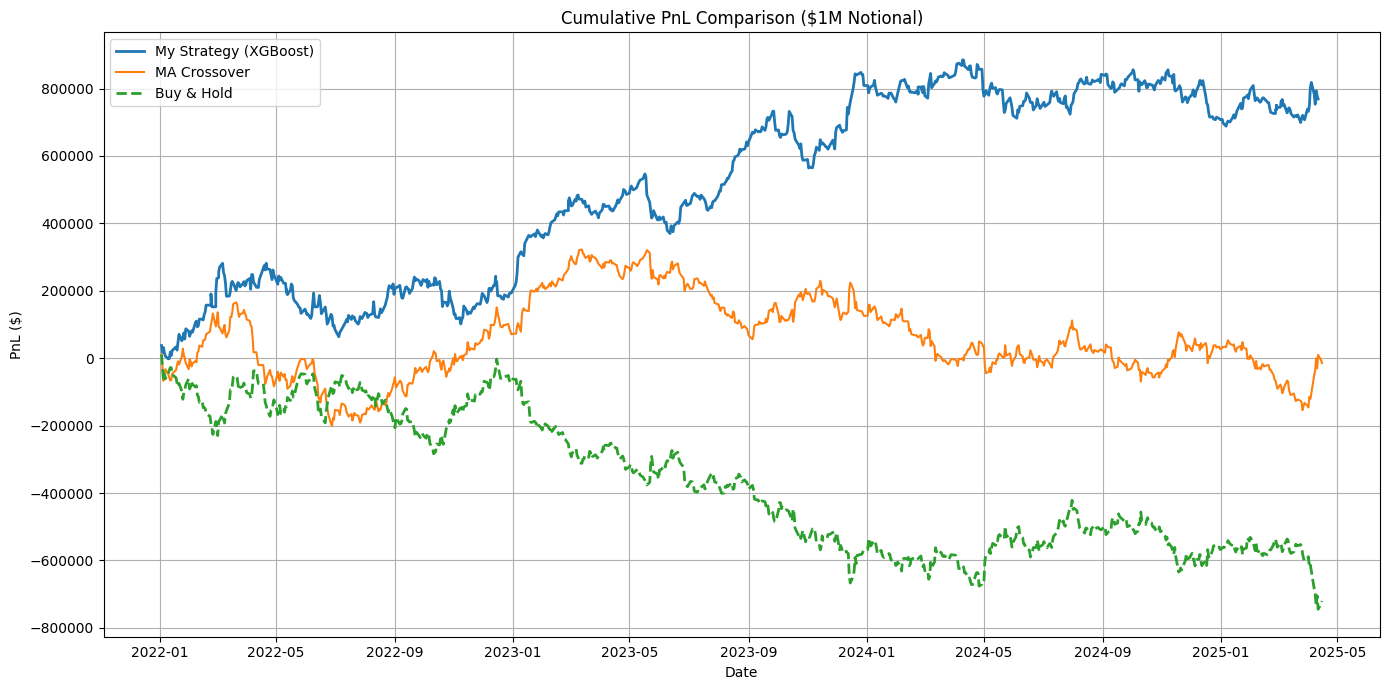

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(strategy_cumulative_pnl, label='My Strategy (XGBoost)', linewidth=2)
plt.plot(ma_pnl.cumsum(), label='MA Crossover')
plt.plot(buyhold_cumulative_pnl, label='Buy & Hold', linewidth=2, linestyle='--')
plt.title('Cumulative PnL Comparison ($1M Notional)')
plt.xlabel('Date')
plt.ylabel('PnL ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation Metrics

In [34]:
daily_returns = strategy_daily_pnl / capital
total_pnl = strategy_daily_pnl.sum()
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
cumulative_returns = (1 + daily_returns).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
win_rate = (strategy_daily_pnl > 0).mean()
gross_profit = strategy_daily_pnl[strategy_daily_pnl > 0].sum()
gross_loss = -strategy_daily_pnl[strategy_daily_pnl < 0].sum()
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf
downside_returns = daily_returns[daily_returns < 0]
sortino_ratio = np.sqrt(252) * daily_returns.mean() / downside_returns.std()
years = len(daily_returns) / 252
annual_return = (1 + daily_returns).prod()**(1/years) - 1
mean_pnl = strategy_daily_pnl.mean()
std_pnl = strategy_daily_pnl.std()

print(f"Mean Daily PnL: ${mean_pnl:,.2f}")
print(f"Std Dev Daily PnL: ${std_pnl:,.2f}")
print(f"Sortino Ratio: {sortino_ratio:.3f}")
print(f"Profit Factor: {profit_factor:.3f}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Total PnL: ${total_pnl:,.2f}")

Mean Daily PnL: $817.22
Std Dev Daily PnL: $14,379.93
Sortino Ratio: 1.278
Profit Factor: 1.173
Win Rate: 46.55%
Max Drawdown: -20.72%
Sharpe Ratio: 0.902
Total PnL: $769,004.38


In [35]:
y_true = y_test['next_day_return']
y_pred = y_test_pred['predicted_return']

residuals = y_true - y_pred
mean_resid = residuals.mean()
std_resid = residuals.std()
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

directional_accuracy = ((y_true * y_pred) > 0).mean()

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")
print(f"Residuals Mean: {mean_resid:.6f}")
print(f"Residuals Std Dev: {std_resid:.6f}")

MAE: 0.010923
RMSE: 0.014905
Directional Accuracy: 46.55%
Residuals Mean: 0.000270
Residuals Std Dev: 0.014911
